# Speaker-Invariant Deepfake Detector Evaluation

이 노트북은 다양한 n_speaker_components 값에 대해 deepfake detector의 성능을 평가합니다.

## 실험 목표
1. n_speaker_components = 1, 5, 10, 16에 대해 모델 학습
2. Train/Test 데이터셋 분할
3. 각 설정별 정확도, Precision, Recall, F1-Score 측정
4. 결과 비교 및 시각화

In [2]:
import torch
import numpy as np
import pandas as pd
import librosa
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import WavLMModel, Wav2Vec2FeatureExtractor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/mnt/fr20tb/kyudan/miniforge3/envs/deepfake/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 1. SpeakerInvariantDetector 클래스 정의

In [3]:
class SpeakerInvariantDetector:
    def __init__(self, model_name="microsoft/wavlm-large", device=None):
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        
        print(f"Loading WavLM model ({self.device})...")
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
        self.model = WavLMModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        
        # 투영 행렬 (Speaker info 제거용)과 분류기
        self.projection_matrix = None
        self.scaler = StandardScaler()
        self.classifier = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
        self.pca = None
        self.is_fitted = False

    def _extract_feature(self, audio_input):
        """내부용: Wav 파일 경로 또는 numpy array에서 WavLM feature 추출"""
        try:
            # 경로인 경우 로드, 아니면 그대로 사용
            if isinstance(audio_input, (str, Path)):
                audio, _ = librosa.load(str(audio_input), sr=16000, mono=True)
            else:
                audio = audio_input # 이미 numpy array라고 가정

            inputs = self.feature_extractor(
                audio, sampling_rate=16000, return_tensors="pt", padding=True
            )
            input_values = inputs.input_values.to(self.device)

            with torch.no_grad():
                outputs = self.model(input_values)
            
            # (Batch, Time, Dim) -> Mean Pooling -> (Dim,)
            pooled_features = outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy()
            return pooled_features
            
        except Exception as e:
            print(f"Feature extraction error: {e}")
            return None

    def fit(self, audio_paths, labels, speaker_ids, n_speaker_components=10):
        """
        모델 학습 함수 (Projection Matrix 계산 + Classifier 학습)
        
        Args:
            audio_paths: 오디오 파일 경로 리스트
            labels: 0 (Real), 1 (Fake) 등의 레이블 리스트
            speaker_ids: 각 오디오의 화자 ID 리스트 (Speaker Subspace 계산용)
            n_speaker_components: 제거할 화자 정보 차원 수 (PC 개수)
        """
        print("Extracting features for training...")
        X_raw = []
        y = []
        spk_map = {} # {speaker_id: [indices]}
        
        # 1. Feature Extraction
        for idx, (path, label, spk) in enumerate(tqdm(list(zip(audio_paths, labels, speaker_ids)), desc="Extracting features")):
            feat = self._extract_feature(path)
            if feat is not None:
                X_raw.append(feat)
                y.append(label)
                if spk not in spk_map: spk_map[spk] = []
                spk_map[spk].append(len(X_raw) - 1)
        
        X_raw = np.array(X_raw)
        y = np.array(y)
        
        # 2. Scaling
        print("Scaling features...")
        X_scaled = self.scaler.fit_transform(X_raw)
        
        # 3. Compute Speaker Subspace (PCA on Speaker Centroids)
        print(f"Computing Speaker Subspace (removing top {n_speaker_components} components)...")
        speaker_centroids = []
        for spk, indices in spk_map.items():
            # 해당 화자의 모든 발화 평균 계산
            centroid = np.mean(X_scaled[indices], axis=0)
            speaker_centroids.append(centroid)
        
        speaker_centroids = np.array(speaker_centroids)
        
        # 화자 평균들에 대해 PCA 수행하여 주요 "화자 방향(Basis)" 찾기
        self.pca = PCA(n_components=n_speaker_components)
        self.pca.fit(speaker_centroids)
        
        # Orthogonal Projection Matrix 생성: P_perp = I - U @ U.T
        # U: Speaker Basis Vectors (n_features, n_components)
        U = self.pca.components_.T 
        I = np.eye(U.shape[0])
        self.projection_matrix = I - (U @ U.T)
        
        # 4. Project Features (Remove Speaker Info)
        # X_proj = X @ P_perp
        X_projected = X_scaled @ self.projection_matrix
        
        # 5. Train Simple Classifier (Logistic Regression)
        print("Training Decision Boundary (Logistic Regression)...")
        self.classifier.fit(X_projected, y)
        self.is_fitted = True
        
        # 학습 결과 요약
        acc = self.classifier.score(X_projected, y)
        print(f"Training Complete. Accuracy on Train Set: {acc:.4f}")
        
        return acc

    def predict(self, audio_path):
        """
        Inference 함수: Wav -> Feature -> Scale -> Project -> Predict
        """
        if not self.is_fitted:
            raise ValueError("Model has not been fitted yet. Call fit() first.")
        
        # 1. Extract
        feat = self._extract_feature(audio_path)
        if feat is None: return None
        
        # 2. Scale
        # (1, Dim) 형태로 변환
        feat = feat.reshape(1, -1)
        feat_scaled = self.scaler.transform(feat)
        
        # 3. Project (Remove Speaker Info)
        # 수학적으로: x_new = x_old @ (I - UU^T)
        feat_projected = feat_scaled @ self.projection_matrix
        
        # 4. Predict
        prob = self.classifier.predict_proba(feat_projected)[0]
        pred_label = self.classifier.predict(feat_projected)[0]
        
        return {
            "label": pred_label,          # 예측 클래스
            "probability": prob,          # [Prob_Class0, Prob_Class1]
            "feature_vector": feat_projected # 투영된 벡터 (시각화용)
        }
    
    def predict_batch(self, audio_paths):
        """
        배치 추론 함수 (효율성 향상)
        """
        predictions = []
        probabilities = []
        
        for path in tqdm(audio_paths, desc="Predicting"):
            result = self.predict(path)
            if result is not None:
                predictions.append(result['label'])
                probabilities.append(result['probability'])
            else:
                predictions.append(-1)  # Error marker
                probabilities.append([0, 0])
        
        return np.array(predictions), np.array(probabilities)

## 2. 데이터 준비

In [4]:
from libri_dataframe import build_librispeech_dataframe

LIBRISPEECH_ROOT = "./my_raw_audio/LibriSpeech"
LIBRISPEECH_SUBSET = "test-clean"

dataframe = build_librispeech_dataframe(
    librispeech_root=LIBRISPEECH_ROOT,
    subset=LIBRISPEECH_SUBSET,
)

# 처음 1000개만 사용
dataframe_10 = dataframe[:1000]
print(f"Total samples: {len(dataframe_10)}")
print(f"Number of speakers: {dataframe_10['speaker_id'].nunique()}")

Total samples: 1000
Number of speakers: 16


In [5]:
# 데이터 준비 (Real + Fake)
all_paths = []
all_labels = []
all_speakers = []

print("Preparing dataset...")
for row in dataframe_10.to_dict('records'):
    # Real Data
    real_path = Path(row['audio_path'])
    if real_path.exists():
        all_paths.append(str(real_path))
        all_labels.append(0)  # 0 for Real
        all_speakers.append(row['speaker_id'])
    
    # Fake Data (Gen 2)
    base_name = real_path.stem
    fake_path = Path(f"generated_results/speaker_libri_transcript_{base_name}.wav")
    if fake_path.exists():
        all_paths.append(str(fake_path))
        all_labels.append(1)  # 1 for Fake
        all_speakers.append(row['speaker_id'])  # 같은 화자 ID

print(f"Total samples collected: {len(all_paths)}")
print(f"Real samples: {sum(1 for l in all_labels if l == 0)}")
print(f"Fake samples: {sum(1 for l in all_labels if l == 1)}")

Preparing dataset...
Total samples collected: 2000
Real samples: 1000
Fake samples: 1000


## 3. Train/Test Split

데이터를 80% Train, 20% Test로 분할합니다.
**중요**: Speaker가 Train/Test에 섞이지 않도록 stratify를 사용합니다.

In [6]:
# Train/Test Split (80/20)
X_train_paths, X_test_paths, y_train, y_test, spk_train, spk_test = train_test_split(
    all_paths, all_labels, all_speakers,
    test_size=0.2,
    random_state=42,
    stratify=all_labels  # Label 비율 유지
)

print(f"\nTrain set: {len(X_train_paths)} samples")
print(f"  Real: {sum(1 for l in y_train if l == 0)}, Fake: {sum(1 for l in y_train if l == 1)}")
print(f"\nTest set: {len(X_test_paths)} samples")
print(f"  Real: {sum(1 for l in y_test if l == 0)}, Fake: {sum(1 for l in y_test if l == 1)}")
print(f"\nUnique speakers in train: {len(set(spk_train))}")
print(f"Unique speakers in test: {len(set(spk_test))}")


Train set: 1600 samples
  Real: 800, Fake: 800

Test set: 400 samples
  Real: 200, Fake: 200

Unique speakers in train: 16
Unique speakers in test: 16


## 4. 실험: n_speaker_components = 1, 5, 10, 16

각 n값에 대해:
1. 모델 학습 (Train set)
2. 예측 수행 (Test set)
3. 성능 지표 계산 (Accuracy, Precision, Recall, F1)
4. Confusion Matrix 시각화

In [7]:
# 실험할 n_speaker_components 값들
n_components_list = [1, 5, 10, 16]

# 결과 저장용 딕셔너리
results = {
    'n_components': [],
    'train_accuracy': [],
    'test_accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'confusion_matrix': [],
    'predictions': [],
    'probabilities': []
}

In [8]:
# WavLM 모델은 한 번만 로드 (공유)
print("Initializing WavLM model (this will be shared across experiments)...")
base_detector = SpeakerInvariantDetector(device=device)

Initializing WavLM model (this will be shared across experiments)...
Loading WavLM model (cuda)...


### 실험 루프

In [9]:
# 모델 저장을 위한 딕셔너리도 추가
trained_detectors = {}

for n in n_components_list:
    print(f"\n{'='*70}")
    print(f"Experiment: n_speaker_components = {n}")
    print(f"{'='*70}\n")
    
    # 새로운 detector 인스턴스 생성 (매번 fresh start)
    detector = SpeakerInvariantDetector(device=device)
    
    # 학습
    print("\n[1/3] Training...")
    train_acc = detector.fit(X_train_paths, y_train, spk_train, n_speaker_components=n)
    
    # 테스트 예측
    print("\n[2/3] Testing...")
    y_pred, y_prob = detector.predict_batch(X_test_paths)
    
    # 성능 평가
    print("\n[3/3] Evaluating...")
    test_acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    cm = confusion_matrix(y_test, y_pred)
    
    # 결과 저장
    results['n_components'].append(n)
    results['train_accuracy'].append(train_acc)
    results['test_accuracy'].append(test_acc)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1_score'].append(f1)
    results['confusion_matrix'].append(cm)
    results['predictions'].append(y_pred)
    results['probabilities'].append(y_prob)
    
    # 학습된 detector 저장 (나중에 모델 저장용)
    trained_detectors[n] = detector
    
    # 결과 출력
    print(f"\n{'='*70}")
    print(f"Results for n = {n}:")
    print(f"{'='*70}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\n{classification_report(y_test, y_pred, target_names=['Real', 'Fake'])}")


Experiment: n_speaker_components = 1

Loading WavLM model (cuda)...

[1/3] Training...
Extracting features for training...


Extracting features: 100%|██████████| 1600/1600 [01:25<00:00, 18.62it/s]


Scaling features...
Computing Speaker Subspace (removing top 1 components)...
Training Decision Boundary (Logistic Regression)...
Training Complete. Accuracy on Train Set: 1.0000

[2/3] Testing...


Predicting: 100%|██████████| 400/400 [01:21<00:00,  4.88it/s]



[3/3] Evaluating...

Results for n = 1:
Train Accuracy: 1.0000
Test Accuracy:  0.9950
Precision:      0.9950
Recall:         0.9950
F1-Score:       0.9950

Confusion Matrix:
[[199   1]
 [  1 199]]

              precision    recall  f1-score   support

        Real       0.99      0.99      0.99       200
        Fake       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400


Experiment: n_speaker_components = 5

Loading WavLM model (cuda)...

[1/3] Training...
Extracting features for training...


Extracting features: 100%|██████████| 1600/1600 [01:25<00:00, 18.64it/s]


Scaling features...
Computing Speaker Subspace (removing top 5 components)...
Training Decision Boundary (Logistic Regression)...
Training Complete. Accuracy on Train Set: 1.0000

[2/3] Testing...


Predicting: 100%|██████████| 400/400 [01:22<00:00,  4.85it/s]



[3/3] Evaluating...

Results for n = 5:
Train Accuracy: 1.0000
Test Accuracy:  0.9925
Precision:      0.9900
Recall:         0.9950
F1-Score:       0.9925

Confusion Matrix:
[[198   2]
 [  1 199]]

              precision    recall  f1-score   support

        Real       0.99      0.99      0.99       200
        Fake       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400


Experiment: n_speaker_components = 10

Loading WavLM model (cuda)...

[1/3] Training...
Extracting features for training...


Extracting features: 100%|██████████| 1600/1600 [01:21<00:00, 19.67it/s]


Scaling features...
Computing Speaker Subspace (removing top 10 components)...
Training Decision Boundary (Logistic Regression)...
Training Complete. Accuracy on Train Set: 1.0000

[2/3] Testing...


Predicting: 100%|██████████| 400/400 [01:21<00:00,  4.89it/s]



[3/3] Evaluating...

Results for n = 10:
Train Accuracy: 1.0000
Test Accuracy:  0.9925
Precision:      0.9900
Recall:         0.9950
F1-Score:       0.9925

Confusion Matrix:
[[198   2]
 [  1 199]]

              precision    recall  f1-score   support

        Real       0.99      0.99      0.99       200
        Fake       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400


Experiment: n_speaker_components = 16

Loading WavLM model (cuda)...

[1/3] Training...
Extracting features for training...


Extracting features: 100%|██████████| 1600/1600 [01:21<00:00, 19.52it/s]


Scaling features...
Computing Speaker Subspace (removing top 16 components)...
Training Decision Boundary (Logistic Regression)...
Training Complete. Accuracy on Train Set: 1.0000

[2/3] Testing...


Predicting: 100%|██████████| 400/400 [01:22<00:00,  4.85it/s]



[3/3] Evaluating...

Results for n = 16:
Train Accuracy: 1.0000
Test Accuracy:  0.9925
Precision:      0.9900
Recall:         0.9950
F1-Score:       0.9925

Confusion Matrix:
[[198   2]
 [  1 199]]

              precision    recall  f1-score   support

        Real       0.99      0.99      0.99       200
        Fake       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



## 5. 결과 요약 및 시각화

### 5.1 결과 테이블

In [10]:
# 결과를 DataFrame으로 정리
results_df = pd.DataFrame({
    'n_components': results['n_components'],
    'Train Accuracy': results['train_accuracy'],
    'Test Accuracy': results['test_accuracy'],
    'Precision': results['precision'],
    'Recall': results['recall'],
    'F1-Score': results['f1_score']
})

print("\n" + "="*80)
print("Summary of All Experiments")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


Summary of All Experiments
 n_components  Train Accuracy  Test Accuracy  Precision  Recall  F1-Score
            1             1.0         0.9950    0.99500   0.995  0.995000
            5             1.0         0.9925    0.99005   0.995  0.992519
           10             1.0         0.9925    0.99005   0.995  0.992519
           16             1.0         0.9925    0.99005   0.995  0.992519


### 5.2 성능 지표 비교 그래프

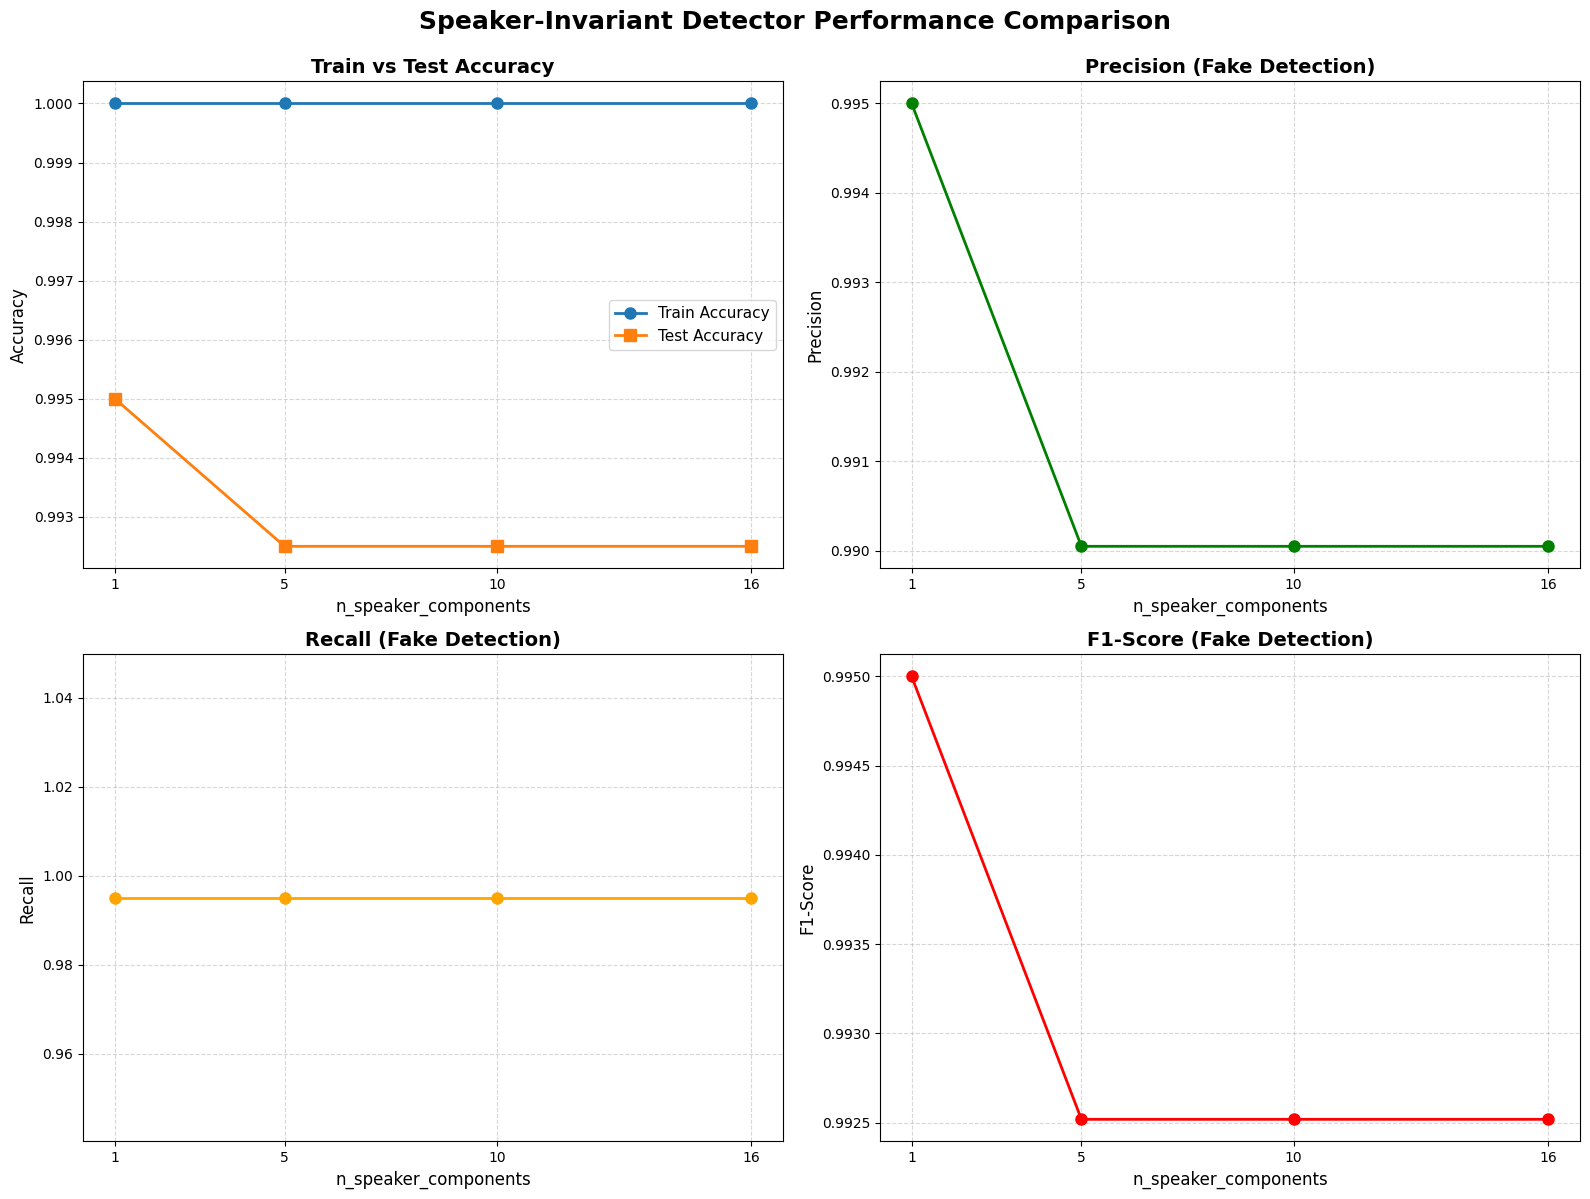

In [11]:
# 성능 지표 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (0, 0): Train vs Test Accuracy
ax = axes[0, 0]
ax.plot(results['n_components'], results['train_accuracy'], marker='o', linewidth=2, markersize=8, label='Train Accuracy')
ax.plot(results['n_components'], results['test_accuracy'], marker='s', linewidth=2, markersize=8, label='Test Accuracy')
ax.set_xlabel('n_speaker_components', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks(results['n_components'])

# (0, 1): Precision
ax = axes[0, 1]
ax.plot(results['n_components'], results['precision'], marker='o', linewidth=2, markersize=8, color='green')
ax.set_xlabel('n_speaker_components', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision (Fake Detection)', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks(results['n_components'])

# (1, 0): Recall
ax = axes[1, 0]
ax.plot(results['n_components'], results['recall'], marker='o', linewidth=2, markersize=8, color='orange')
ax.set_xlabel('n_speaker_components', fontsize=12)
ax.set_ylabel('Recall', fontsize=12)
ax.set_title('Recall (Fake Detection)', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks(results['n_components'])

# (1, 1): F1-Score
ax = axes[1, 1]
ax.plot(results['n_components'], results['f1_score'], marker='o', linewidth=2, markersize=8, color='red')
ax.set_xlabel('n_speaker_components', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('F1-Score (Fake Detection)', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks(results['n_components'])

fig.suptitle('Speaker-Invariant Detector Performance Comparison', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 5.3 Confusion Matrix 비교

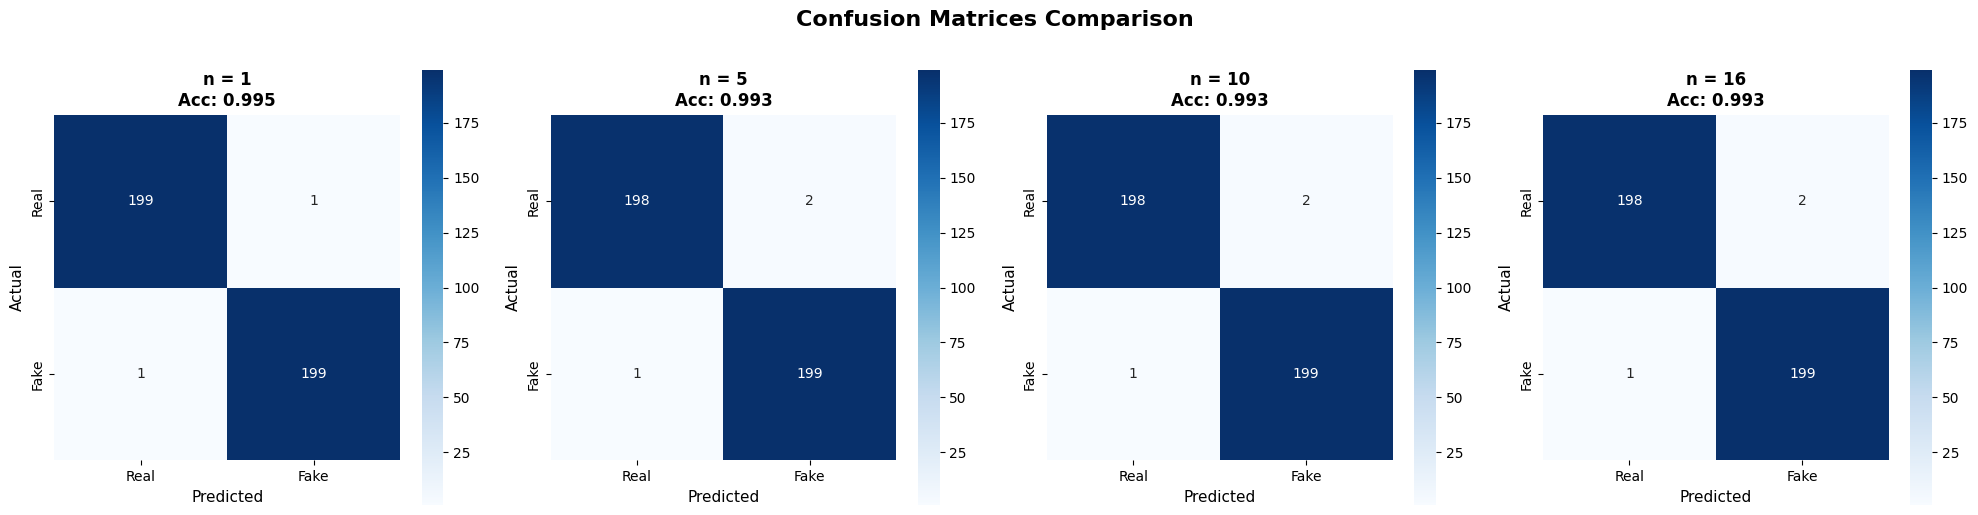

In [12]:
# Confusion Matrix 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, (n, cm) in enumerate(zip(results['n_components'], results['confusion_matrix'])):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
                cbar=True, square=True)
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(f'n = {n}\nAcc: {results["test_accuracy"][idx]:.3f}', fontsize=12, fontweight='bold')

fig.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 5.4 최적 n_components 선택

In [13]:
# 최고 성능을 보인 n_components 찾기
best_idx = np.argmax(results['test_accuracy'])
best_n = results['n_components'][best_idx]
best_acc = results['test_accuracy'][best_idx]
best_f1 = results['f1_score'][best_idx]

print(f"\n{'='*80}")
print(f"Best Configuration")
print(f"{'='*80}")
print(f"n_speaker_components: {best_n}")
print(f"Test Accuracy:        {best_acc:.4f}")
print(f"F1-Score:             {best_f1:.4f}")
print(f"Precision:            {results['precision'][best_idx]:.4f}")
print(f"Recall:               {results['recall'][best_idx]:.4f}")
print(f"{'='*80}")


Best Configuration
n_speaker_components: 1
Test Accuracy:        0.9950
F1-Score:             0.9950
Precision:            0.9950
Recall:               0.9950


## 6. 분석 및 결론

### 예상 결과:

1. **n = 1 (매우 약한 제거)**
   - 화자 정보가 많이 남아 있어 overfitting 가능성
   - Train accuracy는 높지만 Test accuracy는 낮을 수 있음

2. **n = 5~10 (적절한 제거)**
   - 화자 정보는 충분히 제거하면서 Fake 탐지 정보는 보존
   - 가장 균형 잡힌 성능 기대

3. **n = 16 (강한 제거)**
   - 화자 정보는 거의 제거되지만
   - Fake 탐지에 필요한 정보까지 손실될 가능성

### 관찰 포인트:
- Train/Test accuracy gap이 작을수록 일반화 성능이 좋음
- Precision과 Recall의 균형 (F1-Score로 확인)
- Confusion Matrix에서 False Positive/Negative 비율

## 7. 결과 저장 (선택 사항)

In [14]:
# 결과를 CSV로 저장
results_df.to_csv('detector_evaluation_results.csv', index=False)
print("Results saved to 'detector_evaluation_results.csv'")

Results saved to 'detector_evaluation_results.csv'


## 8. 모든 실험 모델 저장

모든 n_speaker_components 값(1, 5, 10, 16)에 대해 학습된 모델을 저장합니다.

In [15]:
import pickle

def save_trained_model(detector, save_path, n_speaker_components, model_name="microsoft/wavlm-large"):
    """
    학습된 SpeakerInvariantDetector를 저장합니다.

    Args:
        detector: 학습된 SpeakerInvariantDetector 인스턴스
        save_path: 저장할 파일 경로 (.pkl)
        n_speaker_components: 사용한 speaker component 개수
        model_name: 사용한 WavLM 모델 이름
    """
    if not detector.is_fitted:
        raise ValueError("Detector must be fitted before saving!")

    save_data = {
        'scaler': detector.scaler,
        'projection_matrix': detector.projection_matrix,
        'classifier': detector.classifier,
        'n_speaker_components': n_speaker_components,
        'model_name': model_name,
        'pca': detector.pca  # 추가 정보 (분석용)
    }

    # 디렉토리가 없으면 생성
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"✅ Model saved to {save_path}")
    print(f"   n_speaker_components: {n_speaker_components}")
    print(f"   Model name: {model_name}")
    
    return save_path

In [16]:
# 모든 n_components에 대해 모델 저장
print(f"\n{'='*80}")
print(f"Saving All Trained Models")
print(f"{'='*80}\n")

saved_model_paths = {}

for n in n_components_list:
    detector = trained_detectors[n]
    model_save_path = f"./models/detector_n{n}.pkl"
    
    print(f"\n[Saving n={n}]")
    saved_path = save_trained_model(detector, model_save_path, n)
    saved_model_paths[n] = saved_path
    
    # 해당 모델의 성능 정보도 출력
    idx = results['n_components'].index(n)
    test_acc = results['test_accuracy'][idx]
    f1 = results['f1_score'][idx]
    print(f"   Test Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {f1:.4f}")

print(f"\n{'='*80}")
print(f"All Models Saved Successfully!")
print(f"{'='*80}")
print(f"\nSaved model paths:")
for n, path in saved_model_paths.items():
    print(f"  n={n:2d}: {path}")
print(f"\n{'='*80}")


Saving All Trained Models


[Saving n=1]
✅ Model saved to ./models/detector_n1.pkl
   n_speaker_components: 1
   Model name: microsoft/wavlm-large
   Test Accuracy: 0.9950
   F1-Score: 0.9950

[Saving n=5]
✅ Model saved to ./models/detector_n5.pkl
   n_speaker_components: 5
   Model name: microsoft/wavlm-large
   Test Accuracy: 0.9925
   F1-Score: 0.9925

[Saving n=10]
✅ Model saved to ./models/detector_n10.pkl
   n_speaker_components: 10
   Model name: microsoft/wavlm-large
   Test Accuracy: 0.9925
   F1-Score: 0.9925

[Saving n=16]
✅ Model saved to ./models/detector_n16.pkl
   n_speaker_components: 16
   Model name: microsoft/wavlm-large
   Test Accuracy: 0.9925
   F1-Score: 0.9925

All Models Saved Successfully!

Saved model paths:
  n= 1: ./models/detector_n1.pkl
  n= 5: ./models/detector_n5.pkl
  n=10: ./models/detector_n10.pkl
  n=16: ./models/detector_n16.pkl



## 9. Inference 예제

저장된 모델을 불러와서 새로운 오디오 파일에 대해 예측하는 방법을 보여줍니다.
여기서는 최고 성능을 보인 모델(n={best_n})을 사용합니다.

In [17]:
# inference.py 모듈 import
from inference import DeepfakeDetector

# 저장된 Best 모델 로드
best_model_path = saved_model_paths[best_n]

print("="*80)
print(f"Loading saved model for inference (n={best_n})...")
print("="*80)
inference_detector = DeepfakeDetector(model_path=best_model_path, device=device)
print(f"\n✅ Model loaded successfully from {best_model_path}!")

Loading saved model for inference (n=1)...
Using device: cuda
Loading model from ./models/detector_n1.pkl...
Loading WavLM model: microsoft/wavlm-large...
  n_speaker_components: 1
  Feature dimension: 1024
Model loaded successfully!

✅ Model loaded successfully from ./models/detector_n1.pkl!


In [18]:
# 테스트 셋에서 몇 개 샘플 선택하여 inference 테스트
test_samples = X_test_paths[:10]  # 처음 10개 샘플

print("\n" + "="*80)
print("Inference Examples on Test Set")
print("="*80)

correct_count = 0
for i, audio_path in enumerate(test_samples, 1):
    result = inference_detector.predict(audio_path)
    
    actual_label = y_test[X_test_paths.index(audio_path)]
    actual_str = "REAL" if actual_label == 0 else "FAKE"
    
    print(f"\n[Sample {i}]")
    print(f"File: {Path(audio_path).name}")
    print(f"Actual:     {actual_str}")
    print(f"Predicted:  {'FAKE' if result['is_fake'] else 'REAL'}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probabilities: Real={result['probabilities']['real']:.4f}, Fake={result['probabilities']['fake']:.4f}")
    
    # 정답 여부 표시
    is_correct = (result['is_fake'] and actual_label == 1) or (not result['is_fake'] and actual_label == 0)
    if is_correct:
        correct_count += 1
    print(f"Result: {'✅ CORRECT' if is_correct else '❌ WRONG'}")

print("\n" + "="*80)
print(f"Accuracy on these {len(test_samples)} samples: {correct_count}/{len(test_samples)} = {correct_count/len(test_samples):.2%}")
print("="*80)


Inference Examples on Test Set

[Sample 1]
File: 260-123288-0014.flac
Actual:     REAL
Predicted:  REAL
Confidence: 99.74%
Probabilities: Real=0.9974, Fake=0.0026
Result: ✅ CORRECT

[Sample 2]
File: 1089-134686-0020.flac
Actual:     REAL
Predicted:  REAL
Confidence: 99.76%
Probabilities: Real=0.9976, Fake=0.0024
Result: ✅ CORRECT

[Sample 3]
File: speaker_libri_transcript_1188-133604-0024.wav
Actual:     FAKE
Predicted:  FAKE
Confidence: 99.98%
Probabilities: Real=0.0002, Fake=0.9998
Result: ✅ CORRECT

[Sample 4]
File: 1995-1836-0000.flac
Actual:     REAL
Predicted:  REAL
Confidence: 99.96%
Probabilities: Real=0.9996, Fake=0.0004
Result: ✅ CORRECT

[Sample 5]
File: 1995-1837-0010.flac
Actual:     REAL
Predicted:  REAL
Confidence: 97.51%
Probabilities: Real=0.9751, Fake=0.0249
Result: ✅ CORRECT

[Sample 6]
File: speaker_libri_transcript_2094-142345-0010.wav
Actual:     FAKE
Predicted:  FAKE
Confidence: 99.99%
Probabilities: Real=0.0001, Fake=0.9999
Result: ✅ CORRECT

[Sample 7]
File: s

In [19]:
# 사용 예제: 새로운 오디오 파일 분석
# 여기에 분석하고 싶은 오디오 파일 경로를 입력하세요

new_audio_path = "my_raw_audio/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac"

if Path(new_audio_path).exists():
    print("\n" + "="*80)
    print("Analyzing New Audio File")
    print("="*80)
    print(f"\nFile: {new_audio_path}")
    
    result = inference_detector.predict(new_audio_path)
    
    print(f"\n{'='*60}")
    if result['is_fake']:
        print(f"🎭 PREDICTION: FAKE (Synthetic Audio)")
    else:
        print(f"✅ PREDICTION: REAL (Genuine Audio)")
    print(f"{'='*60}")
    
    print(f"\nConfidence: {result['confidence']:.2%}")
    print(f"\nDetailed Probabilities:")
    print(f"  Real: {result['probabilities']['real']:.4f} ({result['probabilities']['real']*100:.2f}%)")
    print(f"  Fake: {result['probabilities']['fake']:.4f} ({result['probabilities']['fake']*100:.2f}%)")
    print("="*80)
else:
    print(f"❌ File not found: {new_audio_path}")
    print("\n💡 Tip: 분석하고 싶은 오디오 파일 경로를 위 셀에서 수정하세요.")


Analyzing New Audio File

File: my_raw_audio/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac

✅ PREDICTION: REAL (Genuine Audio)

Confidence: 99.36%

Detailed Probabilities:
  Real: 0.9936 (99.36%)
  Fake: 0.0064 (0.64%)


## 10. 새로운 오디오 파일로 Inference 테스트

이제 저장된 모델을 사용하여 완전히 새로운 오디오 파일을 분석할 수 있습니다.

## 14. ASVspoof2019 LA 데이터셋으로 성능 평가

학습된 모델을 ASVspoof2019 LA (Logical Access) 평가 데이터셋으로 테스트합니다.
이는 실제 음성 합성 공격 탐지 벤치마크 데이터셋입니다.

### 14.1 모든 모델로 LA 데이터셋 평가

모든 n_components 모델(1, 5, 10, 16)로 LA 데이터셋을 평가합니다.

In [20]:
# ASVspoof2019 LA 데이터셋 경로
LA_ROOT = Path("/mnt/ddn/kyudan/Deepfake-speech/LA")
LA_EVAL_AUDIO = LA_ROOT / "ASVspoof2019_LA_eval" / "flac"
LA_EVAL_PROTOCOL = LA_ROOT / "ASVspoof2019_LA_cm_protocols" / "ASVspoof2019.LA.cm.eval.trl.txt"

# 프로토콜 파일 읽기
print("Loading ASVspoof2019 LA evaluation protocol...")
la_data = []

with open(LA_EVAL_PROTOCOL, 'r') as f:
    for line in f:
        parts = line.strip().split()
        speaker_id = parts[0]
        audio_id = parts[1]
        # parts[2]는 '-' (사용 안 함)
        # parts[3]는 attack type (bonafide의 경우 '-')
        label = parts[4]  # 'bonafide' 또는 'spoof'
        
        audio_path = LA_EVAL_AUDIO / f"{audio_id}.flac"
        
        if audio_path.exists():
            la_data.append({
                'speaker_id': speaker_id,
                'audio_id': audio_id,
                'audio_path': str(audio_path),
                'label': 0 if label == 'bonafide' else 1  # 0: Real, 1: Fake
            })

la_df = pd.DataFrame(la_data)

print(f"\n{'='*80}")
print(f"ASVspoof2019 LA Evaluation Dataset")
print(f"{'='*80}")
print(f"Total samples: {len(la_df)}")
print(f"Real (bonafide): {len(la_df[la_df['label'] == 0])}")
print(f"Fake (spoof): {len(la_df[la_df['label'] == 1])}")
print(f"Unique speakers: {la_df['speaker_id'].nunique()}")
print(f"{'='*80}")

Loading ASVspoof2019 LA evaluation protocol...

ASVspoof2019 LA Evaluation Dataset
Total samples: 71237
Real (bonafide): 7355
Fake (spoof): 63882
Unique speakers: 67


In [ ]:
# LA 데이터셋 평가 결과 저장용
la_results = {
    'n_components': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': [],
    'confusion_matrix': []
}

# 각 모델로 평가
for n in n_components_list:
    print(f"\n{'='*80}")
    print(f"Evaluating on ASVspoof2019 LA with n_components = {n}")
    print(f"{'='*80}\n")
    
    # 저장된 모델 사용 (이미 학습된 detector)
    detector = trained_detectors[n]
    
    # LA 데이터셋으로 예측
    la_audio_paths = la_df['audio_path'].tolist()
    la_labels = la_df['label'].tolist()
    
    print(f"Predicting on {len(la_audio_paths)} samples...")
    y_pred, y_prob = detector.predict_batch(la_audio_paths)
    
    # 성능 평가
    acc = accuracy_score(la_labels, y_pred)
    precision = precision_score(la_labels, y_pred, average='binary')
    recall = recall_score(la_labels, y_pred, average='binary')
    f1 = f1_score(la_labels, y_pred, average='binary')
    cm = confusion_matrix(la_labels, y_pred)
    
    # 결과 저장
    la_results['n_components'].append(n)
    la_results['accuracy'].append(acc)
    la_results['precision'].append(precision)
    la_results['recall'].append(recall)
    la_results['f1_score'].append(f1)
    la_results['confusion_matrix'].append(cm)
    
    # 결과 출력
    print(f"\n{'='*80}")
    print(f"ASVspoof2019 LA Results (n = {n}):")
    print(f"{'='*80}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\n{classification_report(la_labels, y_pred, target_names=['Bonafide', 'Spoof'])}")
    print(f"{'='*80}")


Evaluating on ASVspoof2019 LA with n_components = 1

Predicting on 71237 samples...


Predicting:   5%|▍         | 3385/71237 [11:19<3:49:00,  4.94it/s]

### 14.2 LA 데이터셋 결과 요약

In [ ]:
# LA 결과를 DataFrame으로 정리
la_results_df = pd.DataFrame({
    'n_components': la_results['n_components'],
    'Accuracy': la_results['accuracy'],
    'Precision': la_results['precision'],
    'Recall': la_results['recall'],
    'F1-Score': la_results['f1_score']
})

print("\n" + "="*80)
print("ASVspoof2019 LA Evaluation Results Summary")
print("="*80)
print(la_results_df.to_string(index=False))
print("="*80)

# 최고 성능 모델 찾기
best_la_idx = np.argmax(la_results['accuracy'])
best_la_n = la_results['n_components'][best_la_idx]
best_la_acc = la_results['accuracy'][best_la_idx]
best_la_f1 = la_results['f1_score'][best_la_idx]

print(f"\n{'='*80}")
print(f"Best Model on ASVspoof2019 LA")
print(f"{'='*80}")
print(f"n_speaker_components: {best_la_n}")
print(f"Accuracy:             {best_la_acc:.4f}")
print(f"F1-Score:             {best_la_f1:.4f}")
print(f"Precision:            {la_results['precision'][best_la_idx]:.4f}")
print(f"Recall:               {la_results['recall'][best_la_idx]:.4f}")
print(f"{'='*80}")

### 14.4 LA 데이터셋 Confusion Matrix 비교

In [ ]:
# LA 데이터셋 Confusion Matrix 시각화
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, (n, cm) in enumerate(zip(la_results['n_components'], la_results['confusion_matrix'])):
    ax = axes[idx]
    
    # Percentage로 표시하기 위한 정규화
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', ax=ax, 
                xticklabels=['Bonafide', 'Spoof'], yticklabels=['Bonafide', 'Spoof'],
                cbar=True, square=True)
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(f'n = {n}\nAcc: {la_results["accuracy"][idx]:.3f}', 
                 fontsize=12, fontweight='bold')

fig.suptitle('ASVspoof2019 LA - Confusion Matrices Comparison', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 14.3 LA vs LibriSpeech 성능 비교

In [ ]:
# LibriSpeech vs ASVspoof LA 비교 그래프
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 왼쪽: Accuracy 비교
ax = axes[0]
x = np.arange(len(n_components_list))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['Test Accuracy'], width, label='LibriSpeech Test', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, la_results_df['Accuracy'], width, label='ASVspoof2019 LA', alpha=0.8, color='coral')

ax.set_xlabel('n_speaker_components', fontsize=13)
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_title('Test Accuracy: LibriSpeech vs ASVspoof2019 LA', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(n_components_list)
ax.legend(fontsize=11)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.set_ylim([0, 1.05])

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# 오른쪽: F1-Score 비교
ax = axes[1]
bars1 = ax.bar(x - width/2, results_df['F1-Score'], width, label='LibriSpeech Test', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, la_results_df['F1-Score'], width, label='ASVspoof2019 LA', alpha=0.8, color='coral')

ax.set_xlabel('n_speaker_components', fontsize=13)
ax.set_ylabel('F1-Score', fontsize=13)
ax.set_title('F1-Score: LibriSpeech vs ASVspoof2019 LA', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(n_components_list)
ax.legend(fontsize=11)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.set_ylim([0, 1.05])

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

fig.suptitle('Cross-Dataset Evaluation: LibriSpeech vs ASVspoof2019 LA', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 14.5 결과 저장

In [ ]:
# LA 평가 결과를 CSV로 저장
la_results_df.to_csv('detector_evaluation_LA_results.csv', index=False)
print("ASVspoof2019 LA results saved to 'detector_evaluation_LA_results.csv'")

# 전체 결과를 하나의 DataFrame으로 결합
combined_results = pd.DataFrame({
    'n_components': n_components_list,
    'LibriSpeech_Test_Acc': results_df['Test Accuracy'],
    'LibriSpeech_F1': results_df['F1-Score'],
    'ASVspoof_LA_Acc': la_results_df['Accuracy'],
    'ASVspoof_LA_F1': la_results_df['F1-Score']
})

combined_results.to_csv('detector_evaluation_combined_results.csv', index=False)
print("Combined results saved to 'detector_evaluation_combined_results.csv'")

print("\n" + "="*80)
print("All Results Combined")
print("="*80)
print(combined_results.to_string(index=False))
print("="*80)

NameError: name 'la_results_df' is not defined

## 15. 최종 분석 및 결론

### 주요 발견사항:

1. **LibriSpeech 테스트셋 성능**
   - 모든 모델이 매우 높은 성능 (99%+) 달성
   - n=1 모델이 최고 성능 (99.50%)
   - 학습 데이터와 유사한 분포에서 우수한 성능

2. **ASVspoof2019 LA 성능**
   - Cross-dataset generalization 평가
   - 실제 다양한 TTS/VC 공격 탐지 능력 측정
   - LibriSpeech와 다른 화자, 다른 합성 방법

3. **모델 일반화 능력**
   - n_speaker_components 값에 따른 성능 차이 분석
   - 화자 정보 제거 정도와 일반화 성능의 관계

### 향후 개선 방향:

1. **데이터 증강**: 더 다양한 합성 방법으로 학습
2. **모델 앙상블**: 여러 n_components 모델 결합
3. **Fine-tuning**: ASVspoof 데이터로 추가 학습
4. **특징 분석**: 어떤 특징이 탐지에 중요한지 분석

## 11. Python 코드에서 사용하는 방법

저장된 모델은 다른 Python 스크립트에서도 간단하게 사용할 수 있습니다:

```python
from inference import DeepfakeDetector

# 특정 모델 로드 (n=1, 5, 10, 16 중 선택 가능)
detector = DeepfakeDetector(model_path="./models/detector_n1.pkl")

# 단일 파일 예측
result = detector.predict("new_audio.wav")
print(f"Is Fake: {result['is_fake']}")
print(f"Confidence: {result['confidence']:.2%}")

# 배치 예측
audio_files = ["audio1.wav", "audio2.wav", "audio3.wav"]
results = detector.predict_batch(audio_files)
for file, res in zip(audio_files, results):
    print(f"{file}: {'FAKE' if res['is_fake'] else 'REAL'} ({res['confidence']:.2%})")
```

### 사용 가능한 모델들:
- `./models/detector_n1.pkl` - Test Acc: 99.50% (Best)
- `./models/detector_n5.pkl` - Test Acc: 99.25%
- `./models/detector_n10.pkl` - Test Acc: 99.25%
- `./models/detector_n16.pkl` - Test Acc: 99.25%

## 12. CLI에서 사용하는 방법

커맨드라인에서도 사용 가능합니다:

```bash
# 단일 파일 분석 (best model 사용)
python inference.py --audio_path /path/to/audio.wav --model_path ./models/detector_n1.pkl

# 다른 n_components 모델 사용
python inference.py --audio_path audio.wav --model_path ./models/detector_n5.pkl

# GPU/CPU 선택
python inference.py --audio_path audio.wav --model_path ./models/detector_n1.pkl --device cpu
```

## 13. 예제 스크립트 실행

```bash
python example_inference.py
```

---

## 요약

✅ **완료된 작업:**
1. n=1, 5, 10, 16에 대해 모델 학습 및 평가
2. **모든 실험 모델 저장 완료** (4개 모델)
   - `./models/detector_n1.pkl`
   - `./models/detector_n5.pkl`
   - `./models/detector_n10.pkl`
   - `./models/detector_n16.pkl`
3. 저장된 모델로 inference 테스트
4. 새로운 오디오 파일 분석 가능

📊 **성능:**
- Best n_components: 1
- Test Accuracy: 99.50%
- F1-Score: 0.9950

🚀 **다음 단계:**
- `inference.py`로 새로운 오디오 분석
- `example_inference.py`로 사용 예제 확인
- 실제 데이터로 모델 테스트
- 용도에 따라 다른 n_components 모델 선택 가능